In [54]:
import numpy as np
import os
import scipy 
from sympy import *
import pylab as plt
import math
import matplotlib.image as mpimg
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, spherical_yn
#from pdf2image import convert_from_path
%matplotlib inline

In [55]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin
BohrInAng=.529177210544
HartreeInEV=27.2114079527 
hcInEVAngstrom= 1973.269631

In [56]:
def Silvera_Triplet(R):
    x = R * hcInEVAngstrom / 4.16 
    D = 1.28
    K2eV = 8.617e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

def Triplet(x): 
    conv = hcInEVAngstrom / BohrInAng
    R = x * conv
    P = np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    return P * HartreeInEV

def J(Rho):
    R = Rho * hcInEVAngstrom / BohrInAng
    P = np.exp(-.288-.275*R-.176*R**2+.0068*R**3)
    return P * HartreeInEV

def Singlet(R):
    return Silvera_Triplet(R) - J(R)

In [83]:
data = np.genfromtxt('./shortrangesinglet.csv', delimiter=',', skip_header=1)
data2 = np.genfromtxt('./NewerKolos.csv', delimiter=',', skip_header=1)

interp_func = interp1d(data[:,0], data[:,1], kind = 'cubic',fill_value='extrapolate')
interp_funcnew = interp1d(data2[:,0], -data2[:,1], kind = 'cubic',fill_value='extrapolate')

ranges = data[:,0]
singlet_data = data[:,1]

def singlet(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_func(Rp) + 1) * HartreeInEV

new_ranges = np.linspace(.45, 10, 100) / hcInEVAngstrom

def singletnew(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_funcnew(Rp) + 1) * HartreeInEV

def singletcombo(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    split1_2=6.3 # Make the split within the range where function has support (between last 2 bins)
    split2_3=11.5 #  [As above]
    Decide1=(Rp<split1_2)
    Decide2=(Rp>=split1_2)*(Rp<split2_3)
    Decide3=(Rp>=split2_3)

    #return (Decide1*(interp_func(R * 1973) + 1)  + Decide2*(interp_funcnew(R * 1973) + 1) + Decide3*(interp_funcnew(10) + 1)*(R*1973.27/10)**-6) * 27.2114

    return (Decide1*(interp_func(Rp) + 1)  + Decide2*(interp_funcnew(Rp) + 1) + Decide3*(interp_funcnew(split2_3) + 1)*(Rp/split2_3)**-6) * HartreeInEV

/var/folders/vy/ll7qjbxx66v846pybl4qyvh80000gs/T/ipykernel_33485/551406414.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-6,10)


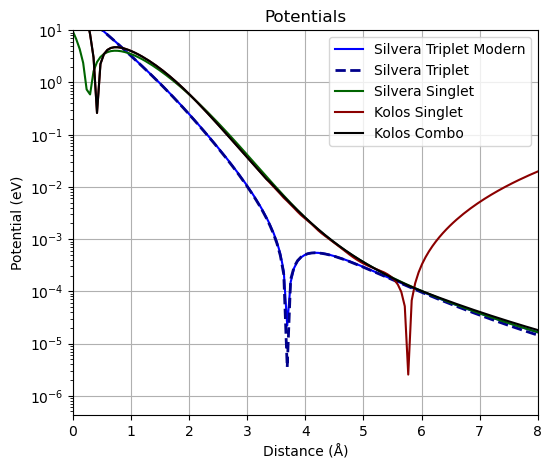

In [84]:
a = .006
rhos = np.linspace(1e-9, a, 200)
plt.figure(figsize=(6, 5))
plt.plot(rhos*hcInEVAngstrom,np.abs(Silvera_Triplet(rhos)), label="Silvera Triplet Modern", color='Blue')
plt.plot(rhos*hcInEVAngstrom,np.abs(Triplet(rhos)), '--', label="Silvera Triplet", color ='DarkBlue', linewidth=2)
plt.plot(rhos*hcInEVAngstrom,np.abs(Singlet(rhos)), label="Silvera Singlet", color='DarkGreen')
plt.plot(rhos*hcInEVAngstrom,np.abs(singlet(rhos)), label="Kolos Singlet", color='DarkRed')
plt.plot(rhos*hcInEVAngstrom,np.abs(singletcombo(rhos)), label="Kolos Combo", color='black')
plt.semilogy()
plt.xlabel("Distance (Å)") 
plt.xlim(0,8)
plt.ylabel("Potential (eV)") 
plt.ylim(-6,10)
plt.title("Potentials")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
def p_of_temp(mu, T):
    J2eV = 6.242e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mu):
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

def p_abs(mu, pin, epsa, epsb, epsprimea, epsprimeb):
    psquared = pin**2 + mu * (epsa + epsb - epsprimea - epsprimeb)
    return np.sqrt(psquared)

In [86]:
def ddx(y, rho, mu, Potential, l, pin):
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]

def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0], rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return (np.sqrt(2/np.pi)*State.y[0]/Normalization[-1],np.sqrt(2/np.pi)*State.y[1]/Normalization[-1])

def GetPhaseShift(bigrho, p, l, r0, mass, version, how_to_int):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    
    State = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[0])
    Statedev = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[1])

    Big = Big_delta_l = (rhos * Statedev - State) / (rhos * State)
    jl_ka = spherical_jn(l, p * rhos)
    jl_prime_ka = spherical_jn(l, p * rhos, derivative=True)
    nl_ka = spherical_yn(l, p * rhos)
    nl_prime_ka = spherical_yn(l, p * rhos, derivative=True)

    #deltas = np.arctan((p*jl_prime_ka - Big_delta_l*jl_ka) / (p*nl_prime_ka - Big_delta_l * nl_ka)) 
    deltas=np.arctan(p*State/Statedev)-p*rhos
    return deltas[-1]

def GetSpatials(mu, B, levels, version_one, version_two):
    aaSpatials = []
    acSpatials = []
    bdSpatials = []
    i = 0
    for bs in B:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        r0 = 1e-9
        temp = 5e-6
        intlimit = 10 * BohrInAng/hcInEVAngstrom #When running with Kolos potential use 10 * when using Silvera potential use 20*

        Pin = p_of_temp(mu, temp)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, c, a, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        const = np.pi / (mu * Pin)
        
        tdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_two, 'Radau')

        aaSpatials.append(11.6 * const * (Pin * Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
        acSpatials.append(11.6 * const * (Pin * Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
        bdSpatials.append(11.6 * const * (Pin * Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))

        i = i + 1

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    bdSpatials = np.array(bdSpatials)

    return(aaSpatials, acSpatials, bdSpatials)

In [87]:
B_Values = np.logspace(-3,1,100)
B_Naught = 1 + B_Values/3.17e-3

In [88]:
def GetHyperFineLevels(pm, mf, delW, mN, gI):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    ge = 2.002319 #Electron g-factor
    meeV = .511e6 #mass of electron
    mue = 9.27e-24 #magnetic moment of electron
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.242e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [89]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
gIH = 5.585694702 # Hydrogen nuclear g-factor
gIT = 5.95792492 
mH = 1.00784 #Mass of hydrogen in Dalton
mT = 3.01604928 

HLevels = AllHFLevels(delWH, mH, gIH)
TLevels = AllHFLevels(delWT, mT, gIT)

Hm = 938.78e6 #Mass of hydrogen in eV/c^2
Tm = 2808.9261e6
Hmu = Hm/2
Tmu = Tm/2

gamH=42.577*1e6 # In Hz T^-1
gamT=45.415*1e6 # In Hz T^-1

In [90]:
e=symbols('e')
c=symbols('c')
s=symbols('s')
sr2=symbols('sr2')
sr3=symbols('sr3')

In [91]:
def LetterToNumber(letter):
    if(letter=="a"):
        return 0
    elif(letter=="b"):
        return 1
    elif(letter=="c"):
        return 2
    elif(letter=="d"):
        return 3
    else:
        print("invalid letter state, "+str(letter))
        assert(0)

In [92]:
def NumberToLetter(num):
    if(num==0):
        return "a"
    elif(num==1):
        return "b"
    elif(num==2):
        return "c"
    elif(num==3):
        return "d"
    else:
        print("invalid number state, "+str(num))
        assert(0)

In [93]:
def StateToBasis(in1,in2,p=1):
    # convert letter basis to number basis
    if(type(in1)==str):
        in1=LetterToNumber(in1)
    else:
        in1=int(in1)
    if(type(in2)==str):
        in2=LetterToNumber(in2)
    else:
        in2=int(in2)
    #swap so first one is always smaller
    if(in2<in1):
        in1old=in1
        in1=in2
        in2=in1old

    if(in1==0 and in2==0 and p==1):
        return 0
    if(in1==1 and in2==1 and p==1):
        return 1
    if(in1==2 and in2==2 and p==1):
        return 2
    if(in1==3 and in2==3 and p==1):
        return 3
    if(in1==0 and in2==1 and p==1):
        return 4
    if(in1==0 and in2==1 and p==-1):
        return 5
    if(in1==0 and in2==2 and p==1):
        return 6
    if(in1==0 and in2==2 and p==-1):
        return 7
    if(in1==0 and in2==3 and p==1):
        return 8
    if(in1==0 and in2==3 and p==-1):
        return 9
    if(in1==1 and in2==2 and p==1):
        return 10
    if(in1==1 and in2==2 and p==-1):
        return 11
    if(in1==1 and in2==3 and p==1):
        return 12
    if(in1==1 and in2==3 and p==-1):
        return 13
    if(in1==2 and in2==3 and p==1):
        return 14
    if(in1==2 and in2==3 and p==-1):
        return 15

In [94]:
SingletProj=np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

TripletProj=np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0,  0.5,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ])

In [95]:
Rotator=[
    [1,  0,  0,  0,  0,  0, 2*e, 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0, -2*e,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -e,  0,  0,  0,  0],
    [-e, 0,  e,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, -e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1]
                ]

    # aa      bb    cc  dd     ab ab  ac     ac  ad  ad  bc  bc  bd  bd  cd  cd 
Rotator=np.array([
    [c*c,     0,    s*s,0,     0,  0,sr2*s*c, 0,  0,  0,  0,  0,  0,  0,  0,  0],   #aa
    [0,       1,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #bb
    [s*s,     0,    c*c,0,     0,  0,-sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],   #cc
    [0,       0,    0,  1,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #dd
    [0,       0,    0,  0,     c,  0,  0,     0,  0,  0,  s,  0,  0,  0,  0,  0],   #ab
    [0,       0,    0,  0,     0,  c,  0,     0,  0,  0,  0,  s,  0,  0,  0,  0],   #ab
    [-sr2*s*c,0,sr2*s*c,0,     0,  0, c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0,  0],   #ac  
    [0,       0,    0,  0,     0,  0,  0,     1,  0,  0,  0,  0,  0,  0,  0,  0],   #ac
    [0,       0,    0,  0,     0,  0,  0,     0,  c,  0,  0,  0,  0,  0,  s,  0],   #ad
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  c,  0,  0,  0,  0,  0,  s],   #ad
    [0,       0,    0,  0,    -s,  0,  0,     0,  0,  0,  c,  0,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  -s, 0,     0,  0,  0,  0,  c,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  1,  0,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  1,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  -s, 0,  0,  0,  0,  0,  c,  0],   #cd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  -s, 0,  0,  0,  0,  0,  c]    #cd
                        ])

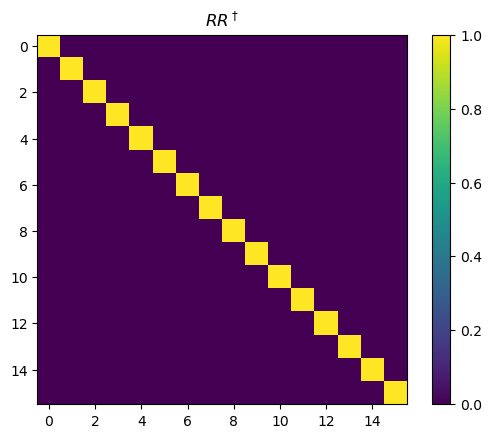

In [96]:
#Check unitarity of rotator matrix

Mat=np.matmul(Rotator,np.transpose(Rotator))
th=0.3
ar=[]
for i in Mat:
    linear=[]
    for j in i:
        if(type(j)!=int):
            linear.append(float(j.subs(sr2,np.sqrt(2)).subs(sr3,np.sqrt(3)).subs(c,np.cos(th)).subs(s,np.sin(th))))
        else:
            linear.append(float(j))
    ar.append(linear)
plt.imshow(ar)
plt.title(r"$R R^\dagger$")
plt.colorbar()

In [97]:
def TransformMatrix(M,R):
    return(np.matmul(np.transpose(R),np.matmul(M,R)))

def RotateByEpsilon(M,eps):
    M1=TransformMatrix(M,Rotator)
    return(EvaluateWithEpsilon(M,eps))

def EvaluateWithEpsilon(M,eps):
    return np.array([(i+0*e).subs(e,eps) for i in M.flatten()]).reshape(M.shape).astype(float)

In [98]:
def GetElement(M,alpha, beta, p1, alphaprime, betaprime, pprime):
    index1=StateToBasis(alpha,beta,p1)
    index2=StateToBasis(alphaprime,betaprime,pprime)
    return(M[index1,index2])

In [99]:
# The notation in Stoof is difficult, and he isnt clear about the values.
# Silvera and Walraven P157 makes it clearer what numbers to use.

magH = 2.821234e-26   #gN * muN
magT = 3.0091e-26     #gN * muN
mage = 1.8569664e-23  #ge * mue  (~2 muB)

hbar =6.62607015e-34
aH=1420.405751773*1e6*hbar
aT=1515.7014708087*1e6*hbar

def Theta(a, B, magN):
    muplus=mage + magN  # In notation of Silvera and Walraven
    return (0.5*np.arctan(a / (B * muplus))) #has large B limit -> a/ (2 muplus B) as reqd

In [100]:

    
def Getspin(a, B_values, magN, a3, a4):
    line = []
    for Bs in B_values:
        th = Theta(a, Bs,magN )
        
        SpinPart = TransformMatrix(TripletProj-SingletProj,Rotator)

        El=(GetElement(SpinPart,"c","c",1,a3,a4,1))**2
        Value=El.subs(sr2,np.sqrt(2)).subs(sr3,np.sqrt(3)).subs(c,np.cos(th)).subs(s,np.sin(th))

        line.append(Value)
    line = np.array(line)
    return line

In [101]:
HSpinaa = Getspin(aH, B_Values, magH, 'a', 'a')
HSpinac = Getspin(aH, B_Values, magH, 'a', 'c')
HSpinbd = Getspin(aH, B_Values, magH, 'b', 'd')
TSpinaa = Getspin(aT, B_Values, magT, 'a', 'a')
TSpinac = Getspin(aT, B_Values, magT, 'a', 'c')
TSpinbd = Getspin(aT, B_Values, magT, 'b', 'd')

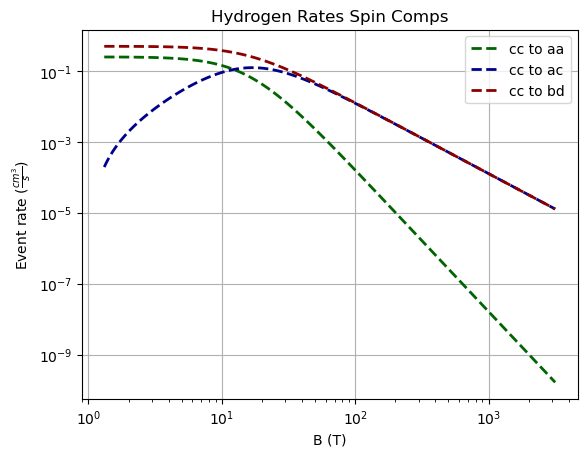

In [102]:
plt.plot(B_Naught, HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Naught, HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Naught, HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spin Comps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

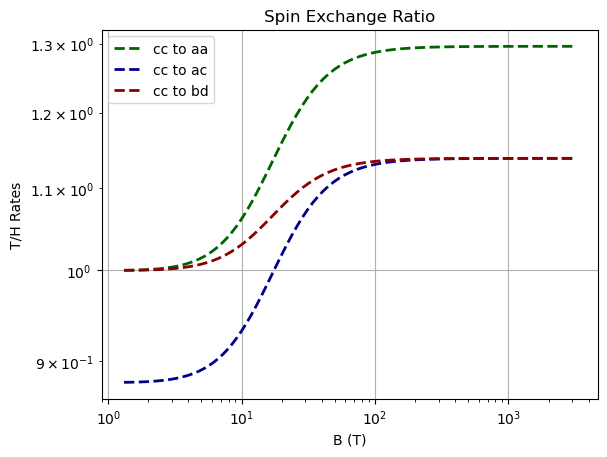

In [103]:
plt.plot(B_Naught, TSpinaa/HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Naught, TSpinac/HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Naught, TSpinbd/HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel("T/H Rates")
plt.title("Spin Exchange Ratio")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

In [104]:
HSpatials = GetSpatials(Hmu, B_Values, HLevels, Silvera_Triplet, singletcombo)
TSpatials = GetSpatials(Tmu, B_Values, TLevels, Silvera_Triplet, singletcombo)

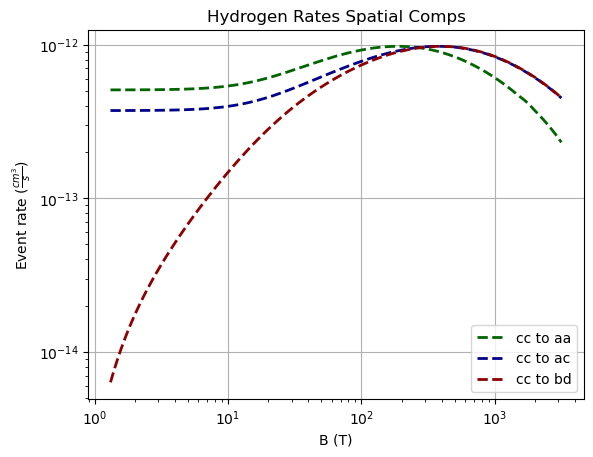

In [105]:
plt.plot(B_Naught,HSpatials[0],  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Naught,HSpatials[1],  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Naught,HSpatials[2],  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Hydrogen Rates Spatial Comps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

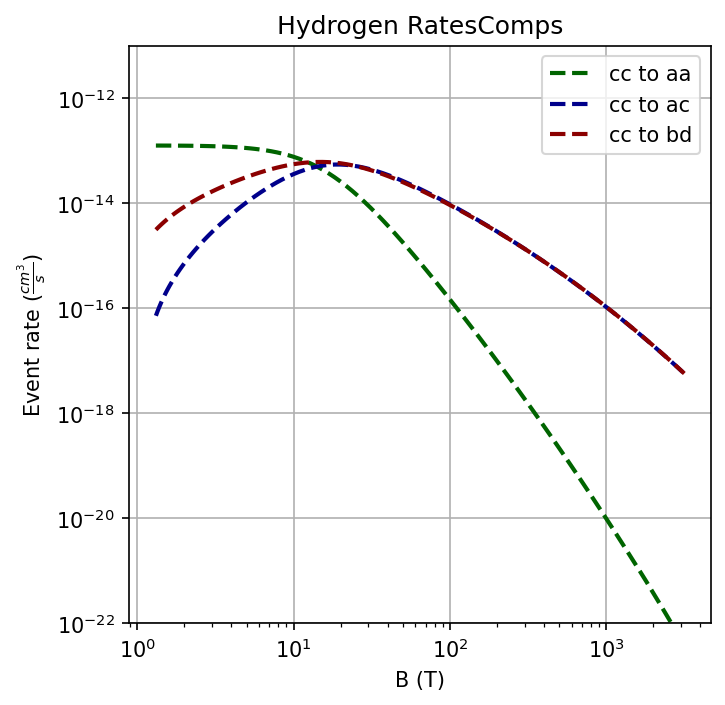

In [106]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Naught,HSpatials[0]*HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Naught,HSpatials[1]*HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Naught,HSpatials[2]*HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-22,1e-11)
plt.title("Hydrogen RatesComps")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

(-21.0, -11.0)

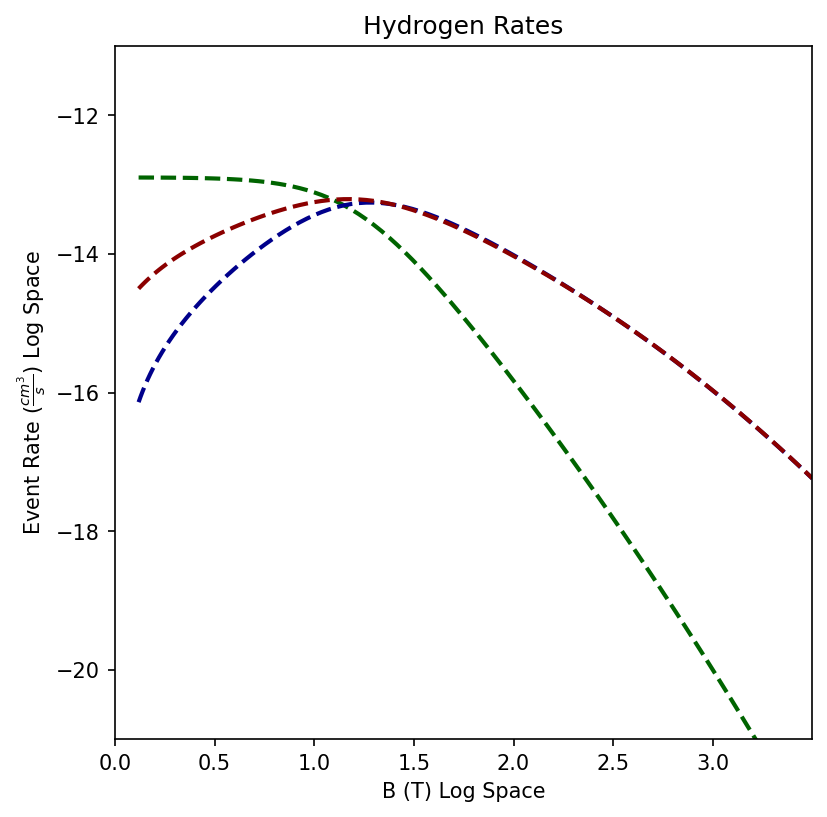

In [107]:
#image = mpimg.imread("/Users/tikitorch/Desktop/one.png")


x_min, x_max = 1, 3155.77
y_min, y_max = 1e-21, 1e-11

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

#ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

B_array = np.array(B_Naught, dtype=float)
B_log = np.log10(B_array)

Haa_array = np.array(HSpatials[0] * HSpinaa, dtype=float)
Hac_array = np.array(HSpatials[1] * HSpinac, dtype=float)
Hbd_array = np.array(HSpatials[2] * HSpinbd, dtype=float)

Haa_log = np.log10(Haa_array)
Hac_log = np.log10(Hac_array)
Hbd_log = np.log10(Hbd_array)

ax.plot(B_log, Haa_log, '--', label="cc to aa (2)", color="DarkGreen", linewidth=2)
ax.plot(B_log, Hac_log, '--', label="cc to ac (5)", color="DarkBlue", linewidth=2)
ax.plot(B_log, Hbd_log, '--', label="cc to bd (3)", color="DarkRed", linewidth=2)

ax.set_xlabel("B (T) Log Space")
ax.set_ylabel(r'Event Rate ($\frac{cm^3}{s}$) Log Space')
ax.set_title("Hydrogen Rates")

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)

In [82]:
p=1e-5
bigrho=10 * Bohr/hcInEVAngstrom
delta=GetPhaseShift(bigrho*10, p, 0, 1e-9, Tmu, Silvera_Triplet, 'Radau')
a_trip=-np.tan(delta)/p
a_trip_natunits=a_trip*197e-9
print("Tritium")
print(str(a_trip) +" eV^-1,  ", str(a_trip_natunits)+" m")



delta=GetPhaseShift(bigrho*10, p, 0, 1e-9, Hmu, Silvera_Triplet, 'Radau')
a_trip=-np.tan(delta)/p
a_trip_natunits=a_trip*197e-9
print("Hydrogen")
print(str(a_trip) +" eV^-1,  ", str(a_trip_natunits)+" m")

NameError: name 'Boh' is not defined

In [ ]:
def Phases_of_B(mu, pont_one, pont_two, B, levels):
    tbdPhase = []
    sbdPhase = []
    
    rhos = np.linspace(1,22,100)*BohrInAng / hcInEVAngstrom
    A = rhos[-1]

    temp = 5e-4
    pin = p_of_temp(mu, temp)
    
    i=0
    for Bs in B:
        ahf = levels['a'][i]
        bhf = levels['b'][i]
        chf = levels['c'][i]
        dhf = levels['d'][i]

        pabs = p_abs(mu, pin, chf, chf, bhf, dhf) 
        tdelta = GetPhaseShift(A, pabs, 0, 1e-9, mu, pont_one, 'Radau')
        sdelta = GetPhaseShift(A, pabs, 0, 1e-9, mu, pont_two, 'Radau')

        tbdPhase.append(tdelta)
        sbdPhase.append(sdelta)

        i=i+1

    tbdPhase = np.array(tbdPhase)
    sbdPhase = np.array(sbdPhase)

    return(tbdPhase, sbdPhase)

def mom_of_B(mu, B_Values, levels):
    mom = []
    temp = 5e-6
    pin = p_of_temp(mu, temp)
    i = 0
    for Bs in B_Values:
        a = levels['a'][i]
        b = levels['b'][i]
        c = levels['c'][i]
        d = levels['d'][i]

        pabs = p_abs(mu, pin, c, c, b, d) 
        mom.append(pabs)
        
        i = i+1
    mom = np.array(mom)
    return mom

In [ ]:
Htdelta, Hsdelta = Phases_of_B(Hmu, Silvera_Triplet, Singlet, B_Values, HLevels)
Ttdelta, Tsdelta = Phases_of_B(Tmu, Silvera_Triplet, Singlet, B_Values, TLevels)

Hmoms = mom_of_B(Hmu, B_Values, HLevels)
Tmoms = mom_of_B(Tmu, B_Values, TLevels)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(Hmoms, Htdelta, label ='Hydrogen Triplet Phase Shift')
plt.plot(Tmoms, Ttdelta, label ='Tritium Triplet Phase Shift')
plt.plot(Hmoms, Hsdelta, label ='Hydrogen Triplet Phase Shift')
plt.plot(Tmoms, Tsdelta, label ='Tritium Triplet Phase Shift')
plt.xlabel("Momentum")
plt.xlim(0,700)
plt.ylabel("Phase Shift")
plt.ylim(-1.5,1.5)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
rhos=np.linspace(1,200,100) * BohrInAng/hcInEVAngstrom

def Phases_of_dis(mu, pont_one, pont_two):
    tbdPhase = []
    sbdPhase = []
    
    for A in rhos:
        p = 1e-3
        tdelta = GetPhaseShift(A, p, 0, 1e-9, mu, pont_one, 'Radau')
        sdelta = GetPhaseShift(A, p, 0, 1e-9, mu, pont_two, 'Radau')

        tbdPhase.append(tdelta)
        sbdPhase.append(sdelta)

    tbdPhase = np.array(tbdPhase)
    sbdPhase = np.array(sbdPhase)

    return(tbdPhase, sbdPhase)

In [ ]:
Ttdelta, Tsdelta = Phases_of_dis(Tmu, Silvera_Triplet, singlet)
Htdelta, Hsdelta = Phases_of_dis(Hmu, Silvera_Triplet, singlet)

Ttdelta2, Tsdelta2 = Phases_of_dis(Tmu, Silvera_Triplet, Singlet)
Htdelta2, Hsdelta2 = Phases_of_dis(Hmu, Silvera_Triplet, Singlet)

In [ ]:

plt.plot(rhos,Htdelta, label="Hydrogen Triplet", color = "DarkGreen", linewidth=2)
plt.plot(rhos,Hsdelta, label="Hydrogen Singlet", color = "DarkRed", linewidth=2)
plt.plot(rhos,Ttdelta, label="Tritium Triplet", color = "DarkGreen", linewidth=1)
plt.plot(rhos,Tsdelta, label="Tritium Singlet", color = "DarkRed", linewidth=1)
plt.xlabel("Int Limit")
#plt.ylim(-2e-5,2e-5)
plt.ylabel("Phase Shifts")
plt.title("Hydrogen Phase Shifts")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(B_Values,TSpatials[0]*TSpinaa/HSpatials[0]*HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
plt.plot(B_Values,TSpatials[1]*TSpinac/HSpatials[1]*HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
plt.plot(B_Values,TSpatials[2]*TSpinbd/HSpatials[2]*HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
plt.xlabel("B (T)")
plt.xlim(.001,.1)
plt.ylabel("Tritium Event Rate/Hydrogen Event Rate")
#plt.ylim(0,10)
plt.title("Spin Exchange Ratios on mK Energy Scale")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
temps = np.linspace (5e-8,5e-6,5)

In [ ]:
for temp in temps:
    def GetSpatials(mu, B, levels, version_one, version_two):
        aaSpatials = []
        acSpatials = []
        bdSpatials = []
        i = 0
        for bs in B:
            a = levels['a'][i]
            b = levels['b'][i]
            c = levels['c'][i]
            d = levels['d'][i]

            r0 = 1e-9
            intlimit = 10 * .53/1973.27 #When running with Kolos potential use 10 * when using Silvera potential use 20*

            Pin = p_of_temp(mu, temp)
            Paa = pprime(Pin, c, c, a, a, mu)
            Pac = pprime(Pin, c, c, c, a, mu)
            Pbd = pprime(Pin, c, c, b, d, mu)
            Pabsaa = p_abs(mu, Pin, c, c, a, a)
            Pabsac = p_abs(mu, Pin, c, c, a, c)
            Pabsbd = p_abs(mu, Pin, c, c, b, d)
    
            const = np.pi / (mu * Pin)
        
            tdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_one, 'Radau')
            tdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_one, 'Radau')
            tdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_one, 'Radau')

            sdeltaaa = GetPhaseShift(intlimit, Pabsaa, 0, r0, mu, version_two, 'Radau')
            sdeltaac = GetPhaseShift(intlimit, Pabsac, 0, r0, mu, version_two, 'Radau')
            sdeltabd = GetPhaseShift(intlimit, Pabsbd, 0, r0, mu, version_two, 'Radau')

            aaSpatials.append(11.6 * const * (Pin * Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
            acSpatials.append(11.6 * const * (Pin * Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
            bdSpatials.append(11.6 * const * (Pin * Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))

            i = i + 1

        aaSpatials = np.array(aaSpatials)
        acSpatials = np.array(acSpatials)
        bdSpatials = np.array(bdSpatials)

        return(aaSpatials, acSpatials, bdSpatials)

    HSpatials = GetSpatials(Hmu, B_Values, HLevels, Silvera_Triplet, singlet)
    TSpatials = GetSpatials(Tmu, B_Values, TLevels, Silvera_Triplet, singlet)

    plt.figure(figsize=(5, 5), dpi = 150)
    plt.plot(B_Naught, HSpatials[0] * HSpinaa,  '--', label="cc to aa", color = "DarkGreen", linewidth=2)
    plt.plot(B_Naught, HSpatials[1] * HSpinac,  '--', label="cc to ac", color = "DarkBlue", linewidth=2)
    plt.plot(B_Naught, HSpatials[2] * HSpinbd,  '--', label="cc to bd", color = "DarkRed", linewidth=2)
    plt.xlabel("B (T)")
    plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
    plt.ylim(1e-21,1e-11)
    plt.title("Hydrogen Rates Spatial Comps")
    plt.grid(True)
    plt.legend()
    plt.loglog()
    plt.show()